## Pulser assignement ##

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, QutipBackend
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform

import matplotlib.pyplot as plt
import networkx as nx

import qutip

Creates the layout matching our problem

In [2]:
def graph_layout(pos, blockade_radius):
    """Creates the graph layout for the given positions and blockade radius.

    Args:
        pos (list): list of the position (x, y) of each atom
        blockade_radius (float): the value of the blockade radius

    Returns:
        Register, int: the register and the maximum Rabi frequency
    """
    reg = Register.from_coordinates(pos)
    Omega_max = MockDevice.rabi_from_blockade(blockade_radius)
    return reg, Omega_max
    

In [3]:
# Define the maximum Rabi frequency by imposing a blockade radius
# (units are um for the blockade radius and rad/us for the rabi frequency)

final_colors = [-1] * 8

blockade_radius = 8.7
initial_pos = [(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)]
reg, Omega_max = graph_layout([(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)], blockade_radius)

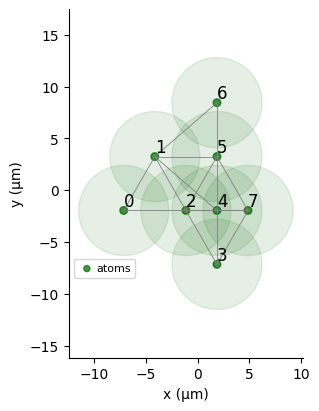

In [4]:
# Visualize the edges induced by the chosen blockade radius
reg.draw(blockade_radius=blockade_radius,  draw_half_radius=True)

The cells below creates a custom graph that will be used to identify the group of each node later

In [5]:
def compute_distance(pos1, pos2):
    """Computes the distance between two points.

    Args:
        pos1 (tuple): the position of the first point
        pos2 (tuple): the position of the second point

    Returns:
        float: the distance between the two points
    """
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def check_element_proximity_in_list(arr, blockade_radius):
    for i in range(len(arr)):
        for j in range(i+1, len(arr)):
            if compute_distance(arr[i], arr[j]) < blockade_radius:
                return True
    return False

def create_edges_from_position_and_distance(pos, blockade_radius):
    edges = []
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            if compute_distance(pos[i], pos[j]) < blockade_radius:
                edges.append((i,j))
    return edges

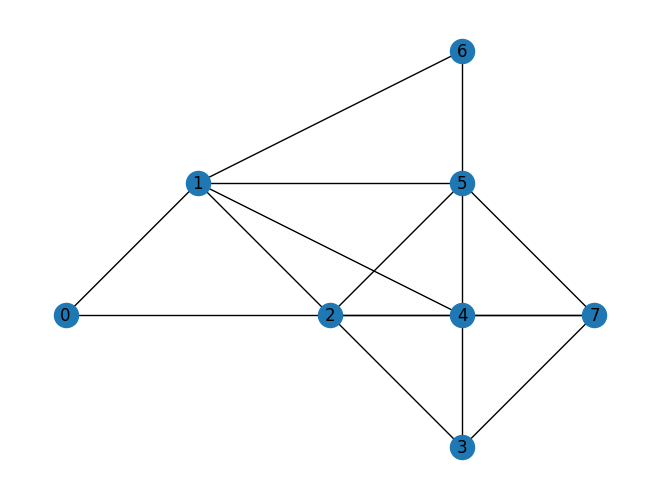

In [6]:
vertices = [0,1,2,3,4,5,6,7]
edges = create_edges_from_position_and_distance(initial_pos, blockade_radius)
pos = {}
for i in range(len(initial_pos)):
    pos[i] = initial_pos[i]

G = nx.Graph()
G.add_nodes_from(vertices)
G.add_edges_from(edges)
nx.draw(G, pos, with_labels=True)

Solving the problem with Pulser

In [7]:
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser import Pulse

In [8]:
def get_pulse(seq):
    """Add the predefined pulses to the sequence.

    Args:
        seq (Sequence): The sequence to which the pulses are added
    """
    # And now we can create the pulse and add it to the channel
 
    #First ramp
    omega_wf_1 = RampWaveform(300, 0, Omega_max) #arguments are duration (ns), initial Omega (rad/us), final Omega (rad/us)
    delta_wf_1 = ConstantWaveform(300, -40) #arguments are duration (ns), detuning (rad/us)
    first_pulse = Pulse(omega_wf_1, delta_wf_1, 0)
    seq.add(first_pulse, 'ch')

    # Do the same for the other two pulses

    # Middle part
    omega_wf_2 = ConstantWaveform(1000, Omega_max)
    delta_wf_2 = RampWaveform(1000, -40, 20)
    middle_pulse = Pulse(omega_wf_2, delta_wf_2, 0)
    seq.add(middle_pulse, 'ch')

    # Final ramp
    omega_wf_3 = RampWaveform(300, Omega_max, 0)
    delta_wf_3 = ConstantWaveform(300, 20)
    final_pulse = Pulse(omega_wf_3, delta_wf_3, 0)
    seq.add(final_pulse, 'ch')

In [9]:
# A Sequence is the object that contains all the info about the quantum evolution
seq = Sequence(reg, MockDevice)

#Channel declaration
seq.declare_channel('ch', 'rydberg_global')

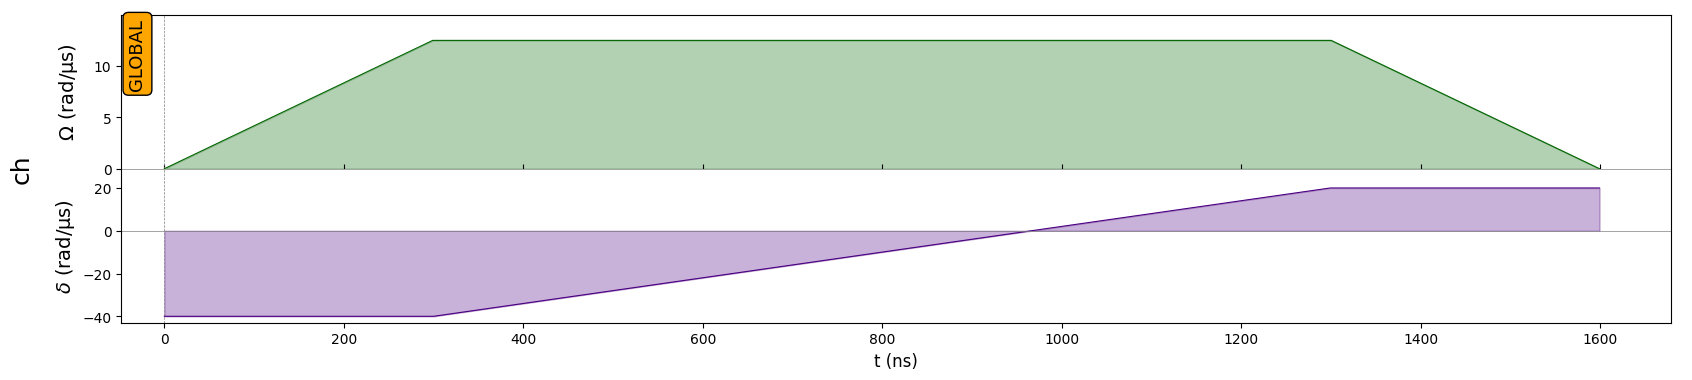

In [10]:
get_pulse(seq)

seq.draw()

Applying The pulses to solve our MIS problem

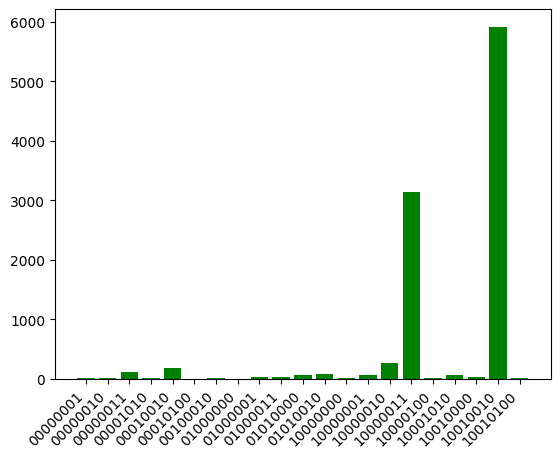

476.1904761904762

In [11]:
sim = QutipBackend(seq)
res = sim.run()
shots = 10000
sampl = res.sample_final_state(shots)
plt.bar(sampl.keys(), sampl.values(),color='g')
#make the graph bi1gger because the labels are too close
plt.xticks(rotation=45, ha="right")
plt.show()

threshold = shots/len(sampl)
threshold

In [12]:
# Get the key with the maximum value
colors = list(sampl.keys())[list(sampl.values()).index(max(list(sampl.values())))][::-1]
print("Here is the best separation in two groups", colors)

Here is the best separation in two groups 01001001


Let's check the colored graph

In [13]:
def from_grp_to_colors(group):
    """Simply replace the numbers by colors name.

    Args:
        group (list): list of groups of antennas as integers

    Returns:
        list: list of groups of antennas as colors
    """
    possible_colors = ['red','blue','green','purple','yellow', 'white', 'black']
    color_index = 0
    grp_colors = ['black'] * len(group)
    grp_checked = []
    for i in range(len(group)):
        ele = group[i]
        if ele not in grp_checked:
            grp_checked.append(ele)
            color = possible_colors[color_index]
            for y in range(i, len(group)):
                if group[i] == group[y]:
                    grp_colors[y] = color
            color_index += 1
    return grp_colors

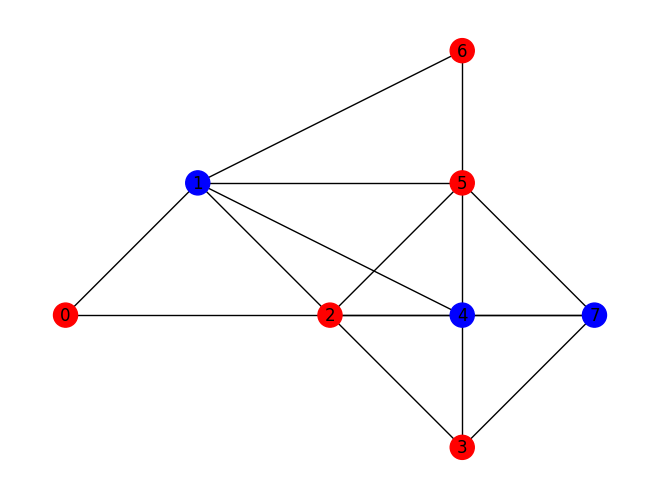

In [14]:
naive_first_separation = []
for ele in colors:
    naive_first_separation.append(int(ele))
    
naive_colors = from_grp_to_colors(naive_first_separation)
nx.draw(G, pos, node_color=naive_colors, with_labels=True)

Many close antyennas are still in the same frequencies.

Let's reapply our algorithm on the red and blue groups to separate the close nodes.

In [15]:
# Creates the list used to differentiate the two groups
#The Nodes positions
zeros = []
#The index matching the position in the original array of positions
zeros_index = []
ones = []
ones_index = []
for i in range(len(colors)):
    grp = colors[i]
    if grp == '0':
        zeros.append(initial_pos[i])
        zeros_index.append(i)
    else:
        ones.append(initial_pos[i])
        ones_index.append(i)



## ZEROS ##
Let's apply MIS algorithm to the sub graph "zero"

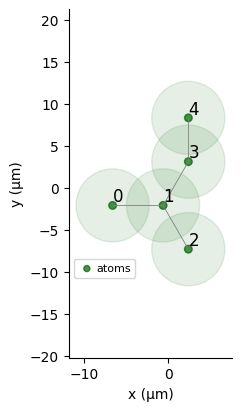

In [16]:
reg_zeros, Omega_max = graph_layout(zeros, blockade_radius)
reg_zeros.draw(blockade_radius=blockade_radius,  draw_half_radius=True)

In [17]:
# A Sequence is the object that contains all the info about the quantum evolution
seq_zeros = Sequence(reg_zeros, MockDevice)

#Channel declaration
seq_zeros.declare_channel('ch', 'rydberg_global')
get_pulse(seq_zeros)


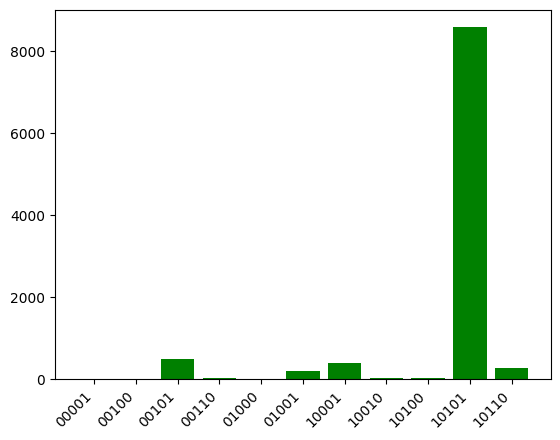

909.0909090909091

In [18]:
sim = QutipBackend(seq_zeros)
res = sim.run()
shots = 10000
sampl = res.sample_final_state(shots)
plt.bar(sampl.keys(), sampl.values(),color='g')
#make the graph bi1gger because the labels are too close
plt.xticks(rotation=45, ha="right")
plt.show()

threshold = shots/len(sampl)
threshold

In [19]:
color_index = 0
colors_zeros  = list(sampl.keys())[list(sampl.values()).index(max(list(sampl.values())))][::-1]
for i in range(len(colors_zeros)):
    grp = colors_zeros[i]
    if grp == '0':
        final_colors[zeros_index[i]] = color_index
    else:
        final_colors[zeros_index[i]] = color_index + 1

print(final_colors)
color_index += 2

[1, -1, 0, 1, -1, 0, 1, -1]


## ONES ##

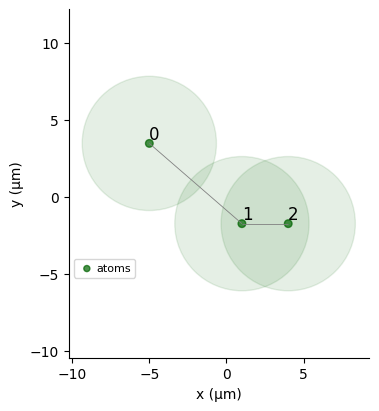

In [20]:
reg_ones, Omega_max = graph_layout(ones, blockade_radius)
reg_ones.draw(blockade_radius=blockade_radius,  draw_half_radius=True)

In [21]:
# A Sequence is the object that contains all the info about the quantum evolution
seq_ones = Sequence(reg_ones, MockDevice)

#Channel declaration
seq_ones.declare_channel('ch', 'rydberg_global')
get_pulse(seq_ones)

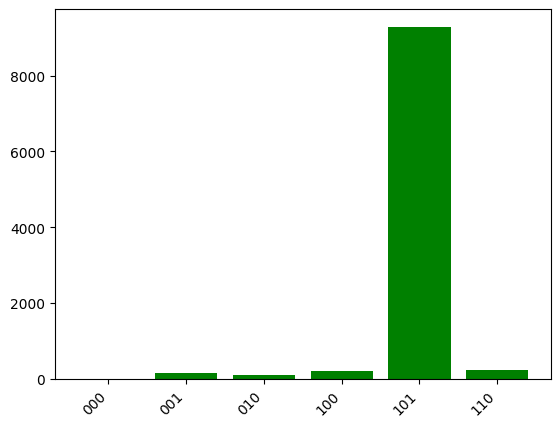

1666.6666666666667

In [22]:
sim = QutipBackend(seq_ones)
res = sim.run()
shots = 10000
sampl = res.sample_final_state(shots)
plt.bar(sampl.keys(), sampl.values(),color='g')
#make the graph bi1gger because the labels are too close
plt.xticks(rotation=45, ha="right")
plt.show()

threshold = shots/len(sampl)
threshold

In [23]:

colors_ones  = list(sampl.keys())[list(sampl.values()).index(max(list(sampl.values())))][::-1]
for i in range(len(colors_ones)):
    grp = colors_ones[i]
    if grp == '0':
        final_colors[ones_index[i]] = color_index
    else:
        final_colors[ones_index[i]] = color_index + 1

print(final_colors)

[1, 3, 0, 1, 2, 0, 1, 3]


Here are the new groups we get when we apply the algorithm to the 2 sub-groups

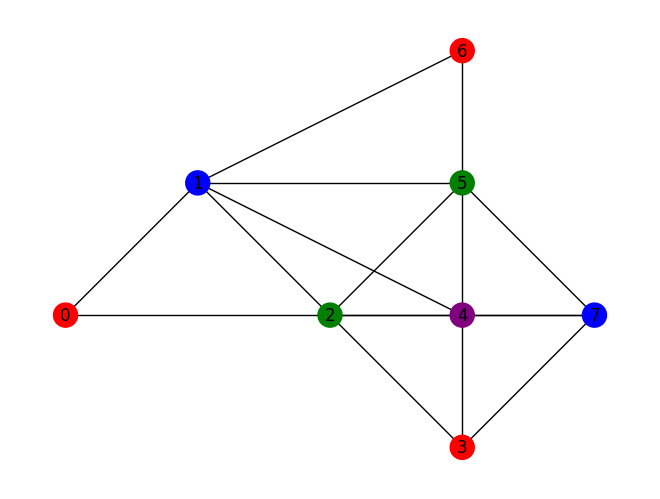

In [24]:
better_colors = from_grp_to_colors(final_colors)
nx.draw(G, pos, node_color=better_colors, with_labels=True)

Better results but still not perfect.

We need to continue apply the algorithm as long as one group still has at least two antennas close 

## AUTO ##

Here is the automatic version that continues to run on the sub-groups until no groups has any close antenna or until the algorithm doesn't find any new separation 

In [25]:
def compute_distance(pos1, pos2):
    """Computes the distance between two points.

    Args:
        pos1 (tuple): the position of the first point
        pos2 (tuple): the position of the second point

    Returns:
        float: the distance between the two points
    """
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def check_element_proximity_in_list(arr, blockade_radius):
    for i in range(len(arr)):
        for j in range(i+1, len(arr)):
            if compute_distance(arr[i], arr[j]) < blockade_radius:
                return True
    return False

In [26]:

def get_the_groups(arr, blockade_radius, final_colors, index_list, color_grp=0):
    """The function that recursively call the MIS algorithm on the groups to find the best groups of atoms.

    Args:
        arr (list): list of the position of the atoms/antennas to separate  
        blockade_radius (float): the minimum distance allowed between antennas
        final_colors (list): The array describing the group of each antenna
        index_list (list): a list of index used to fill final colors at the right position
        color_grp (int, optional): the current index of the colors. Defaults to 0.

    Returns:
        list, int: The upadated group list and the current index of the colors
    """

    # Model our antennas as Rydberg atoms
    reg, _ = graph_layout(arr, blockade_radius)
    # A Sequence is the object that contains all the info about the quantum evolution
    seq = Sequence(reg, MockDevice)

    #Channel declaration
    seq.declare_channel('ch', 'rydberg_global')
    get_pulse(seq)

    sim = QutipBackend(seq)
    res = sim.run()
    shots = 10000
    sampl = res.sample_final_state(shots)

    # The best separation found in two groups found with our pulse
    colors  = list(sampl.keys())[list(sampl.values()).index(max(list(sampl.values())))][::-1]
    
    # Use the result from the MIS to add the nodes in the groups 
    for i in range(len(colors)):
        grp = colors[i]
        if grp == '0':
            final_colors[index_list[i]] = color_grp
        else:
            final_colors[index_list[i]] = color_grp + 1

    # If the MIS did not find any separation
    if colors == '0' * len(colors) or colors == '1' * len(colors):
        return final_colors, color_grp
    
    # Divide the two groups found in 2 distinct list
    first_grp = []
    f_grp_index = []
    second_grp = []
    s_grp_index = []
    for i in range(len(colors)):
        grp = colors[i]
        if grp == '0':
            first_grp.append(arr[i])
            f_grp_index.append(index_list[i])
        else:
            second_grp.append(arr[i])
            s_grp_index.append(index_list[i])
    color_grp += 2

    # IF one group has two close element then recursively call the function
    if check_element_proximity_in_list(first_grp, blockade_radius):
        final_colors, color_grp = get_the_groups(first_grp, blockade_radius, final_colors, f_grp_index, color_grp)

    color_grp += 2
    # Same for the second group
    if check_element_proximity_in_list(second_grp, blockade_radius):
        final_colors, color_grp = get_the_groups(second_grp, blockade_radius, final_colors, s_grp_index, color_grp)
    color_grp += 2
    
    return final_colors, color_grp

In [27]:
#print(final_colors.copy())
#do_shit(zeros, blockade_radius, final_colors.copy(), zeros_index, 0)
initial_index = [i for i in range(len(initial_pos))]
grp_automatize , _ = get_the_groups(initial_pos, blockade_radius, final_colors.copy(), initial_index, 0)
print("Group separation found: ", grp_automatize)

Group separation found:  [3, 17, 5, 3, 16, 4, 3, 17]


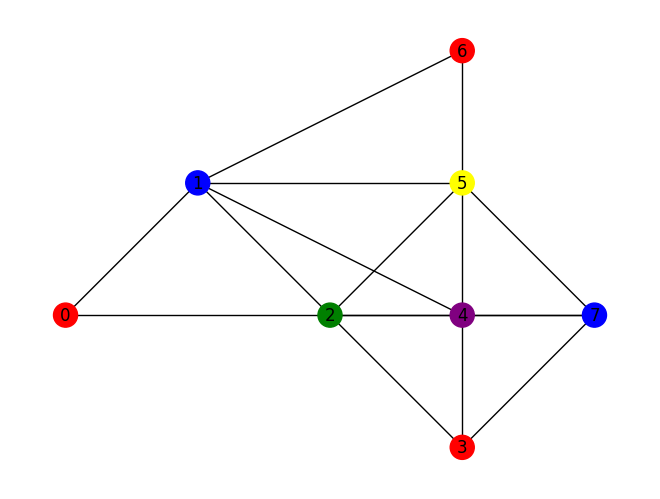

In [28]:
auto_colors = from_grp_to_colors(grp_automatize)
nx.draw(G, pos, node_color=auto_colors, with_labels=True)

This version finds a decent result but it could be better as shown in this graph using only foor frequencies:

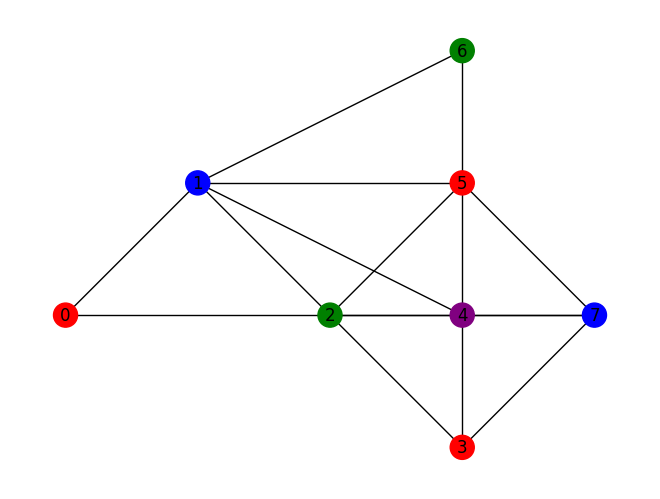

In [29]:
manual_colors = ['red','blue','green','red','purple', 'red', 'green', 'blue']
nx.draw(G, pos, node_color=manual_colors, with_labels=True)